# **BUSI 488 / COMP 488 Data Science in the Business World**
## *Spring 2023*  
Daniel M. Ringel  
Kenan-Flagler Business School  
*The University of North Carolina at Chapel Hill*  
dmr@unc.edu

## Class 15 - Ensemble Learning

*March 2, 2023*  
Version 2.1

![ensemble](https://music.unc.edu/files/2013/09/1484014_10151881768213591_277633653_o.jpg)

**Ensemble learning** is the process by which multiple models, such as classifiers, are generated and combined to solve a particular problem better than single models could.    

Ensemble learning is commonly used in machine learning to improve classification or regression models.

# Today's Agenda

1. **Strengths and Limitations of CARTs**
2. **Wisdom of the Crowds in Machine Learning**
3. **Ensemble Learning with Bootstrap Aggregation (BAGGING)**
4. **Empirical Application of BAGGING: Predicting Loan Eligibility**
5. **Ensemble Learning with Random Forests: Pooling Experts**
6. **Adaptive Boosting: Can a Bunch of Fools beat the Experts?**
7. **Gradient Boosting with XGBoost**


## Prep-Check:
- Reviewed Notebook from Class 14

# 1. Strengths and Limitations of CARTs
*Classification and Regression Trees (CARTs)*

## Strengths
- Clear Box
- Simple to understand
- Simple to interpret
- Easy to use
- Flexibility: ability to describe non-linear dependencies
- Preprocessing: no need to standardize or normalize features

## Limitations
- Classification: can only produce orthogonal decision boundaries
- Sensitive to small variations in the training set
- High variance: unconstrained CARTs may ovefit the training set
- Solution: Wisdom of the Crowds!

## Consequence:
- As far as accuracies of prediction go, Decision Trees are quite inaccurate. 
- Even one mis-step in the choice of the next node, can lead you to a completely different end. 
- Choosing the right branch instead of the left could lead you to the furthest end of the tree. 
- You would be off by a huge margin!



# 2. Wisdom of the Crowds in Machine Learning

### *When you are uncertain about a decision:* 
1. You might ask several people for their assessment ... 
2. ... and then make a more informed decision.




## It's April 2022: Will BitCoin go up?


![bitcoin](https://mapxp.app/BUSI488/Bitcoin-2022.png)
[source: CNBC](https://www.cnbc.com/2022/12/23/bitcoin-price-calls-in-2022-how-the-market-got-it-wrong.html#:~:text=Cryptocurrencies%20have%20been%20under%20pressure%20after%20the%20collapse%20of%20major%20exchange%20FTX.&text=2022%20marked%20the%20start%20of,of%20digital%20currencies%20crashing%20spectacularly)


- You have access to a dozen great analysts who have no prior knowledge about BitCoin. 
- Each analyst has a low bias because they don’t have no prior assumptions.
- Each analyst can learn about BitCoin from a dataset of news reports. 
- Each analyst has a high variance in their predicition when there is variation in the reports they receive.  

***Having access to news reports seems ideal for the task!***

### Problem: The reports are likely to contain noise in addition to real signals.

**Because your analysts will base their predictions entirely on the data (they have complete flexibility how), they can be swayed by irrelevant information.**


### Consequence:
* The analysts might each come up with very differing predictions from the same set of reports. 
* Each analyst might come up with dramatically different predicition when they are given a different set of reports.


### ***The solution is to not rely on any one individual, but pool the votes of multiple analysts.***



# 3. Ensemble Learning with Bootstrap Aggregation (BAGGING)

- Uses a technique known as ***bootstrapping***.
- Reduces variance of individual models in an **ENSEMBLE** of the same algorithm
- One algorithm with different subsets of the training set.

### ***Basic Idea:*** Create multiple Decision Trees based on bootstrapped samples and go with the majority vote of the trees!

![BAGGING](https://mapxp.app/BUSI488/BAGGINGCART2.gif)

# 4. Empirical Application of BAGGING: ***Predicting Eligibility for a Loan***

[*Based on an Analytics Vidhya practice competition*](https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/)

A Fintech wants to automate the loan eligibility process (in real time) based on the details that applicants provide in their online application. These details are:

- Gender
- Marital Status
- Education
- Number of Dependents
- Income
- Loan Amount
- Credit History and others. 

To automate this process, the Fintech needs to assign applicants to either being eligible for the requested loan (amount), or not. You are provided with a training dataset in which the loan eligibility is marked. 
The dataset contains the following variables:

| Variable          	| Description                     	|
|-------------------	|---------------------------------	|
| Loan_ID           	| Unique Loan ID                  	|
| Gender            	| Male/ Female                    	|
| Married           	| Applicant married (Y/N)         	|
| Dependents        	| Number of dependents            	|
| Education         	| Graduate/ Under Graduate        	|
| Self_Employed     	| Self employed (Y/N)             	|
| ApplicantIncome   	| Applicant income                	|
| CoapplicantIncome 	| Coapplicant income              	|
| LoanAmount        	| Loan amount in thousands        	|
| Loan_Amount_Term  	| Term of loan in months          	|
| Credit_History    	| credit history meets guidelines 	|
| Property_Area     	| Urban/ Semi Urban/ Rural        	|
| Loan_Status       	| Loan approved (Y/N)             	|

You can download the dataset ***loan_train.csv*** from CANVAS along with the notebook of this class.

## 4.1 Load the Data

In [ ]:
# 1. Connect out notebook with out Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 2. Navigate to the directory in which we saved the data file(s)
%cd /content/gdrive/MyDrive/488/Class15 

/content/gdrive/MyDrive/488/Class15


In [ ]:
# 3. Check what files are in the current directory
!ls # special shell command to view the files in the home directory of the notebook environment (! command has no lasting effect)

488_2023_Class15.ipynb	loan_train.csv


In [ ]:
# 4. Load data file into a pandas dataframe
import pandas as pd
data = pd.read_csv("loan_train.csv") # parse to a Pandas DataFrame using pd.read_csv()
display(f"Observations in Dataset: {len(data)}")

'Observations in Dataset: 614'

## 4.2 Preprocess Data in one Step!

We create functions that take care of all the preprocessing steps for us.  

***What is the advantage of doing so?***

In [ ]:
# 1a Import some libraries that you will need for this step
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# 2 Let's create two functions that help us with the preprocessing to make it faster and easier to execute

# 2a OUTLIER DETECTION (we will call this function within our preprocessing function that we define next in 2b)
'This function can be used on any dataset to return a list of index values for the outliers (based on standard deviation)'
'Only appropriate for numerical features'
def get_outliers(data, columns, nsd=7):
    # we create an empty list
    outlier_idxs = []
    # Apply to columns
    for col in columns:
        elements = data[col]
        # we get the mean value for each column
        mean = elements.mean()
        # and the standard deviation of the column
        sd = elements.std()
        # we then get the index values of all values higher or lower than the mean +/- nsd standard deviations
        outliers_mask = data[(data[col] > mean + nsd*sd) | (data[col]  < mean  - nsd*sd)].index
        # and add those index values to our list
        outlier_idxs  += [x for x in outliers_mask]
    return list(set(outlier_idxs))

# 2b Put all the PREPROCESSING from class 14 into a function
'Function that receives the loan eligibility raw data'
'as well as the imputation strategies for categorical and numerical features'
'and runs all preprocessing steps'
'Outputs a data object that contains features and response variable'
def prepro(df,numimp,catimp):
      #2b1 The first column (Loan_ID) is not informative to our task. So let's drop it!
      df=df.drop(['Loan_ID'],axis=1)

      #2b2 Make your work easy: Automatically identify which features are numeric and which are categorical. 
      # To do so, create two indices that hold the colum names of our data set that are numerical and categorical, respectively
      # Make sure that you do not include our response variable here, since this is just about features!
      numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
      categorical_features = df.select_dtypes(include=['object', 'category']).drop(['Loan_Status'], axis=1).columns

      #2b3 What about Credit_History? Should that not be a categorical variable?
      numeric_features=numeric_features.drop('Credit_History')
      categorical_features=categorical_features.insert(6, 'Credit_History') 
    
      #2b4 Now typecast all variables that are categorical as type "category"
      for col in categorical_features.tolist():
              df[col] = df[col].astype('category')

      #2b5 Don't forget to also typecast our response variable as category
      df['Loan_Status'] = df['Loan_Status'].astype('category')   

      #2b6 Let's identify and remove outliers for the numerical variables using the function we created in 2a above
      outs = get_outliers(df, numeric_features)
      df = df.drop(outs, axis = 0)

      #2b7a Now you need to impute missing numerical values. What imputation strategy will you choose?
      imputer = SimpleImputer(missing_values = np.nan, strategy = numimp)
      imputer = imputer.fit(df[numeric_features.tolist()])
      df[numeric_features.tolist()] = imputer.transform(df[numeric_features.tolist()])

      #2b7b Now you need to impute missing categorical values. 
      imputercat = SimpleImputer(missing_values = np.nan, strategy = catimp)
      imputercat = imputercat.fit(df[categorical_features.tolist()])
      df[categorical_features.tolist()] = imputercat.transform(df[categorical_features.tolist()])
      df['Credit_History'] = df['Credit_History'].astype('category')   # imputer set type back to numeric, so we correct it again

      #2b8 Create a new dataframe X that includes only our feature variables
      feat = df.loc[:, df.columns != 'Loan_Status']

      #2b9 Create a new dataframe y that includes only our 
      lab = df.Loan_Status

      #2b10 Now you need to one hot encode the categorical features to make them machine readable. 
      feat = pd.get_dummies(feat)

      #2b11 And re-code the response variable using a dictionary and replace
      repmap={"Y": 1, "N": 0}
      lab.replace(repmap, inplace=True)

      #2b12 Feature engineer Household_Income_log (why log?) and add it to our features (X)
      feat['Household_Income_log']=np.log(feat.ApplicantIncome + feat.CoapplicantIncome)

      #2b13 Feature engineer EMI and add it to our features (X) --> See class 14 for details on intution and formal euqations
      r = 0.06/12
      feat['EMI']=np.ceil(feat['LoanAmount']*1000*r*((1+r)**feat['Loan_Amount_Term'])/((1+r)**feat['Loan_Amount_Term']-1)*100)/100

      #2b14 Append our two new features to our numerical features
      numeric_features=numeric_features.insert(len(numeric_features),'EMI') 
      numeric_features=numeric_features.insert(len(numeric_features),'Household_Income_log') 
      
      #2b15 Return the features (feat) and labels (lab)
      return feat, lab, numeric_features

#### ***Let's apply our functions to the data!***

In [ ]:
# 3. Call PREPROCESSING function and pass it the dataframe as well as the imputation strategies for (1) numerical and (2) categorical features
data = prepro(data,'median','most_frequent') 

# 4. Separate features (X) and labels (y) from data object
X=data[0]
y=data[1]

# 5. Get numerical features
numeric_features = data[2]

# 6. Verify that it worked
display(X.head())
display(y.head())
display(numeric_features)
display(f"Observations after Preprocessing: {len(X)}")

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,...,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Credit_History_0.0,Credit_History_1.0,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Household_Income_log,EMI
0,5849.0,0.0,127.0,360.0,0,1,1,0,1,0,...,0,1,0,0,1,0,0,1,8.674026,761.43
1,4583.0,1508.0,128.0,360.0,0,1,0,1,0,1,...,0,1,0,0,1,1,0,0,8.714568,767.43
2,3000.0,0.0,66.0,360.0,0,1,0,1,1,0,...,0,0,1,0,1,0,0,1,8.006368,395.71
3,2583.0,2358.0,120.0,360.0,0,1,0,1,1,0,...,1,1,0,0,1,0,0,1,8.505323,719.47
4,6000.0,0.0,141.0,360.0,0,1,1,0,1,0,...,0,1,0,0,1,0,0,1,8.699515,845.37


0    1
1    0
2    1
3    1
4    1
Name: Loan_Status, dtype: int64

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'EMI', 'Household_Income_log'],
      dtype='object')

'Observations after Preprocessing: 609'

## 4.3 Baseline Predicition with a Classification Tree

### Let's take a look at how well we can predict customer eligibility using a Classification Tree

In [ ]:
# 1. Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# 2. Import train_test_split
from sklearn.model_selection import train_test_split

# 3. Import accuracy_score
from sklearn.metrics import accuracy_score

# 4. Split dataset into 70% train, 30% test
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 5. Instantiate dt, set 'criterion' to 'gini'
dt = DecisionTreeClassifier(criterion='gini', random_state=1)

# 6. Fit dt to the training set
dt.fit(X_train,y_train)

# 7. Predict test-set labels
y_pred_dt = dt.predict(X_test)

### So how well does our Classification Tree do?

In [ ]:
# 8. Output the accuracy of our prediction
from sklearn.metrics import accuracy_score
print(f"Accuracy of Decision Tree Classifier is {round(accuracy_score(y_test, y_pred_dt)*100,2)}%")

Accuracy of Decision Tree Classifier is 74.32%


## 4.4 Improved Prediction with BAGGING

![Forest](https://mapxp.app/BUSI488/paperbags3.jpg)

In [ ]:
# 1. Import models and utility functions
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 2. Split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# 3. Instantiate a classification-tree 'dt'
dt = DecisionTreeClassifier(criterion='gini')

# 4. Instantiate a BaggingClassifier 'bc'
bc = BaggingClassifier(estimator=dt, n_estimators=25, n_jobs=-1,random_state=42)

# 5. Fit 'bc' to the training set
bc.fit(X_train, y_train)

# 6. Predict test set labels
y_pred_bag = bc.predict(X_test)

# 7. Output the accuracy of our prediction
print(f"Accuracy of Bagging Classifier is {round(accuracy_score(y_test, y_pred_bag)*100,2)}%")

Accuracy of Bagging Classifier is 79.23%


# 5. Ensemble Learning with Random Forests: Pooling Experts
![Forest](https://mapxp.app/BUSI488/trees.jpg)

### Building a Random Forest

There are 4 steps involved in building a random forest:

    1. Create a ‘bootstrapped dataset’ from the original data.
    2. Create a decision tree using these bootstrapped data: sample features
    3. Rinse and Repeat 1 and 2 to create more decision trees.
    4. Take majority vote (Classification) or average (Regression)



### Feature Randomness  

In a normal decision tree, when it is time to split a node, we consider every possible feature and pick the one that produces the most separation between the observations in the left node vs. those in the right node.   

In contrast, each tree in a random forest can pick only from a random subset of features.  

**This forces even more variation amongst the trees in the model and ultimately results in lower correlation across trees and more diversification.**

A large number of relatively uncorrelated models (trees) operating as a committee will outperform any of the individual constituent models.


![BAGGING](https://mapxp.app/BUSI488/RandomForest2.gif)

## 5.1 Improved Prediction with a Random Forest

In [ ]:
# 1. Basic imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 2. Split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.3,
stratify=y,
random_state=42)

# 3. Instantiate a random forests classifier
rf = RandomForestClassifier(n_estimators=25, bootstrap = True, max_features = 'sqrt', min_samples_leaf = 5, criterion='gini', random_state=42)

# 4. Fit 'rf' to the training set
rf.fit(X_train, y_train)

# 5. Predict the test set labels 'y_pred'
y_pred_rf = rf.predict(X_test)

# 6. Output the accuracy of our prediction
print(f"Accuracy of Random Forest Classifier is {round(accuracy_score(y_test, y_pred_rf)*100,2)}%")

Accuracy of Random Forest Classifier is 83.06%


# 6. Adaptive Boosting: Can a Bunch of Fools beat the Experts?
![Idiots](https://mapxp.app/BUSI488/3stooges.jpg)
___ 
#### *I'd rather rely on a hundred fools that learn from each other's mistakes, than a hundred opinionated experts.*
*Daniel M. Ringel*   
___ 

**We saw that many experts can improve prediction. We call it *Random Forests*.**  

Let's see if a bunch of fools can do better than our experts in the Random Forest!




## 6.1 Boosting

**Boosting:** Ensemble method combining several weak learners to form a strong learner.  

**Weak learner:** Model doing slightly better than random guessing.  

**Example of weak learner:** Decision stump (CART whose maximum depth is 1).  


**Basic Idea:**
- Train an ensemble of predictors sequentially.
- Each predictor tries to correct its predecessor.
- Most popular boosting methods:
    * AdaBoost
    * Gradient Boosting

## 6.2 AdaBoost

- Stands for **Adaptive Boosting**.
- Each predictor pays more attention to the instances wrongly predicted by its predecessor.
- Achieved by changing the weights of training instances.
- Each predictor is assigned a coefficient $\alpha$.
- $\alpha$ (alpha) depends on the predictor's training error.
- $\eta$ (eta) is the learning rate (shrinkage of $\alpha$)
    * small $\eta$ means the models trains slower (and sometimes better), but you need more estimators

![AdaBoostProcess](https://mapxp.app/BUSI488/AdaBoostProcess.jpg)


### AdaBoost used both for Classification and Regression
- Classification:
    * Weighted majority voting.
    * In sklearn: AdaBoostClassifier
- Regression:
    * Weighted average.
    * In sklearn: AdaBoostRegressor
    
    
*Source: DataCamp*

## 6.3 Random Forest vs. AdaBoost (aka Experts vs. Fools)

#### Basic Idea of a Random Forest
- Each tree is a full-size tree
- Each tree can look different in terms of depth and splits
- Each tree can use multiple features to make a decision
- Each tree has equal weight in voting
- Each tree is made independently of the others
- Most trees have different samples to operate on (because of bootstrapping)


#### Basic Idea of AdaBoost for Decision Trees
- Usually uses stumps (root node with two leaves)
- Forest of stumps
- Stumps can only use one variable to make a decision (split)
- Stumps are not good at making accurate classifications = weak learners
- Some stumps have a greater say (i.e., significance) in the voting at the end than others (weighted by their accuracy)
- Stump order matters! Stumps are created in sequence, whereby the next stump implicitly takes the errors made by its predecessor into account for its own classification.


## 6.4 Steps in the AdaBoost Algorithm
1. Initialize a weight ($w_r$) for each record that indicates how important it is for the classification.  
   At the start, all records get the same weight ($1/R$), which makes them equally important.    
    
   
2. Make the best split: Determining which feature to split on based on the information gain (see class on decision trees for details)  


3. Determine the total error of the stump: Sum of the weights ($w_r$) of the incorrectly classified records.  


4. Use the error of the classifier (i.e., the share of misclassified records) to determine how much say (i.e., vote) the particular stump has in the final classification, which is captured by $\alpha$ (also referred to as significance).  


5. Update (i.e., increase or decrease) the weights ($w_r$) for the records based on $\alpha$   
   and normalize all weights so that they sum to 1 (i.e., divide ***all*** records' weights by their sum).  
   
   
6. Create a new dataset of records:
    - of the same shape as the original dataset (i.e., the same number of rows and columns) 
    - based on the normalized sample weights
    - by drawing $R$ records (with replacement)
    - where for each of $R$ draws you generate a random number between 0 and 1
    - and add the record to the new dataset whose cumulative weight (i.e., the sum of weights of all records "above" it in the table)
    - the randomly drawn number falls into.

    
7. Repeat steps 2-6. 

## 6.5 Calculating Alpha
$\alpha_t= \frac{1}{2}ln\left ( \frac{1-\epsilon_t}{\epsilon_t} \right )= \;Significance\; = \frac{1}{2}ln\left ( \frac{1-Total\; Error_t}{Total\;  Error_t} \right )$

***Let's visualize Alpha for different error rates:***

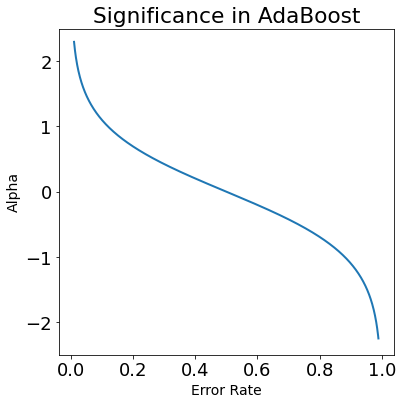

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 18  # makes label size bigger
plt.figure(figsize=(6,6))
t = np.arange(0.01, 0.99, 0.001)
s = (1/2)*np.log((1-t)/t)
line, = plt.plot(t, s, lw=2)
plt.ylim(-2.5, 2.5)
plt.xlabel('Error Rate',fontsize = 14)
plt.ylabel('Alpha',fontsize = 14)
plt.title('Significance in AdaBoost')
plt.show()

**The above graph shows the intuition behind alpha in the final vote of the AdaBoost classifier:**

1. The classifier weight grows exponentially as the error approaches 0.   
    *Better classifiers are given exponentially more weight.*  
    

2. The classifier weight is zero if the error rate is 0.5.   
     *A classifier with 50% accuracy is no better than random guessing, so we ignore it.*  
     

3. The classifier weight grows exponentially negative as the error approaches 1.   
     *We give a negative weight to classifiers with worse than 50% accuracy.*   
     *Whatever that classifier says, do the opposite!* 

## 6.6 Updating the Weights
We now update the weight for each record based on how well the current stump did overall and specifically for each record. 

**Incorrectly classified records**

$w_{r,t+1} = w_{r,t} \times e^{\alpha_t} = New \;Record \;Weight \;= \;Record \;Weight \;\times\; e^{Significance}$

*There is nothing fancy going on here!*  
*All we do is raise $e$ to the power of the significance $\alpha_t$*  
*so that the new record weight grows exponentially*  
*(which increases its chance of being drawn for the sample of the next stump).*  


**Correctly classified records**  
Finally, look at the records that the tree classified correctly,  
and decrease their associated weights using the following formula:  

$w_{r,t+1} = w_{r,t} \times e^{- \alpha_t} = New \;Record \;Weight \;= \;Record \;Weight \;\times \;e^{- Significance}$

**Normalize Weights**  
Finally, we normalize all weights (for all records) by dividing the new weights by the sum of new weights.   

$\frac{w_{r,t+1}}{\sum_{r\in R}w_{r,t+1}}$


## 6.7 Constructing the New  Dataset

![AdaBoost1200](https://mapxp.app/BUSI488/AdaBoost1200.jpg)

## 6.8 Desirable Outcomes! 

**Records which the previous stump incorrectly classified**
- should be associated with larger weights ...   
  ... so that they are more likely to be in the sample of the next stump   
  
  
- than the records that the current stump classified correctly ...   
  ... which will receive smaller weights and are thus less likely to be drawn in the next sample    
  


**Since the records that were incorrectly classified** have higher weights in relation to the others,   
      ... the likelihood that the random number falls under their slice of the distribution is greater
   
**Consequence:** 
-  The new dataset will have a tendency to contain multiple copies of the records that were misclassified by the previous tree
- When we go back to the step where we evaluate the predictions made by each decision tree,   
  the one with the highest score will have correctly classified the records the previous tree misclassified.


## 6.9 Let's have some Fools predict loan eligibility! (AdaBoost) 

![chainsaw](https://mapxp.app/BUSI488/chainsaw.jpg)

In [ ]:
# Import models and utility functions
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import IPython
from sklearn.model_selection import train_test_split

# Split data into 70% train and 30% test
#Already done: X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# # Instantiate an "fool" classification-tree 'fool'
fool = DecisionTreeClassifier(max_depth=1, criterion='gini', min_samples_leaf = 5, splitter = "random")

# Instantiate an AdaBoost classifier 'adab_clf'
adb_clf = AdaBoostClassifier(estimator=fool, n_estimators=25, learning_rate=.3, random_state=42)

# Fit 'adb_clf' to the training set
adb_clf.fit(X_train, y_train)

# Predict the test data
y_pred_ada = adb_clf.predict(X_test)

### ***So how about them fools?***
Can they do better? Let's check!

In [ ]:
from sklearn.metrics import accuracy_score
print(f'Decision Tree Accuracy: {round(accuracy_score(y_test, y_pred_dt)*100,2)}%')
print(f'Bagging Accuracy: {round(accuracy_score(y_test, y_pred_bag)*100,2)}%')
print(f'Random Forest Accuracy: {round(accuracy_score(y_test, y_pred_rf)*100,2)}%')
print(f'Adaptive Boosting Accuracy: {round(accuracy_score(y_test, y_pred_ada)*100,2)}%')
if accuracy_score(y_test, y_pred_ada) > accuracy_score(y_test, y_pred_rf): IPython.display.display(IPython.display.Audio(url="https://mapxp.app/BUSI488/foolswin.wav", autoplay=True))  

Decision Tree Accuracy: 74.32%
Bagging Accuracy: 79.23%
Random Forest Accuracy: 83.06%
Adaptive Boosting Accuracy: 84.7%


# 7. XGBoost: Extreme Gradient Boosting

***XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.***

- Scalable, distributed gradient-boosted decision tree (GBDT) machine learning library.
- Uses ensemble learning, that is, an ensemble of decision trees.
- Implements machine learning algorithms under the Gradient Boosting framework. 
- Provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. 
- The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

**Gradient boosting** is 
- An extension of boosting where the process of additively generating weak models is formalized as a gradient descent algorithm over an objective function. 
- Gradient boosting sets targeted outcomes for the next model in an effort to minimize errors. 
- Targeted outcomes for each case are based on the gradient of the error (hence the name gradient boosting) with respect to the prediction.

***Random forest “bagging” minimizes the variance and overfitting, whereas GBDT “boosting” minimizes the bias and underfitting.***

*XGBoost is the leading machine learning library for regression, classification, and ranking problems:* 



[Read more about XGBoost](https://xgboost.readthedocs.io/en/stable/index.html)

In [ ]:
# Import XGBoost
import xgboost as xgboost

# Instantiate Classifier
xgb = xgboost.XGBClassifier(n_estimators=9, subsample=.8,colsample_bytree=.2, eta=.3, seed=42)

# Fit Classifier to training data
xgb.fit(X_train, y_train)

# Predict test data with trained classifier
y_pred_xg = xgb.predict(X_test)

# Evaluate performance of test predictions
print(f'Extreme Gradient Boosting Accuracy: {round(accuracy_score(y_test, y_pred_xg)*100,2)}%')

Extreme Gradient Boosting Accuracy: 85.25%


In [ ]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [5, 7, 8,9, 10, 15],
    'subsample': [0.5, 0.8],
    'colsample_bytree': [0.2, 0.5],
    'eta': [0.1, 0.3, 0.5],
    'seed': [42]
}

# Instantiate the XGBoost classifier
xgb = xgb.XGBClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding accuracy score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best hyperparameters and the corresponding accuracy score
print("Best hyperparameters: ", best_params)
print("Best accuracy score: ", best_score)

Best hyperparameters:  {'colsample_bytree': 0.2, 'eta': 0.1, 'n_estimators': 7, 'seed': 42, 'subsample': 0.8}
Best accuracy score:  0.7910533515731875


# **Looking Ahead:**  

####**Next Class:** Tuesday, March 7, 2023 

#### ***Model Performance and Generalization Errors***

#### Reading: None



This notebooks is in part based on the following excellent tutorials:

https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76  
https://towardsdatascience.com/understanding-random-forest-58381e0602d2  
https://medium.com/x8-the-ai-community/building-intuition-for-random-forests-76d36fa28c5e  
https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb  